                                                   
#**ASSIGNMENT 2**
#**Electricity Consumption Analysis**


# **Task 1 — EDA**

***Loading the dataset***

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


#Creating dataframe and load the dataset
df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=';', low_memory=False)

***Load the model using below code after saving it***

In [9]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/File and Model/lstm_power_model.h5", compile=False)


***Showing the count of total columns and rows***

In [10]:
print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])

Total rows: 2075259
Total columns: 9


***Prints first 10 rows of dataset***

In [11]:
df.head(10)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.220,15.800,0.000,1.000,17.0
8,16/12/2006,17:32:00,3.668,0.510,233.990,15.800,0.000,1.000,17.0
9,16/12/2006,17:33:00,3.662,0.510,233.860,15.800,0.000,2.000,16.0


In [12]:
#Showing datatypes of columns
df.dtypes

,0
Date,object
Time,object
Global_active_power,object
Global_reactive_power,object
Voltage,object
Global_intensity,object
Sub_metering_1,object
Sub_metering_2,object
Sub_metering_3,float64


***Combine Date and Time into a single timestamp***

In [13]:
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df = df.set_index('Timestamp')

In [14]:
df.replace("?", pd.NA, inplace=True)        #Replacing the null values as NA
df = df.dropna()                            #Droping Null Values

***Below comment checks whether null values are exist or not and counting it***

In [15]:
df.isna().sum()

,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


***Below code converts ONLY numeric columns to float***

In [16]:
numeric_cols = ['Global_active_power', 'Global_reactive_power','Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df[numeric_cols] = df[numeric_cols].astype(float)
df.dtypes

,0
Date,object
Time,object
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


***Below code shows the Plot time-series of Global_active_power***

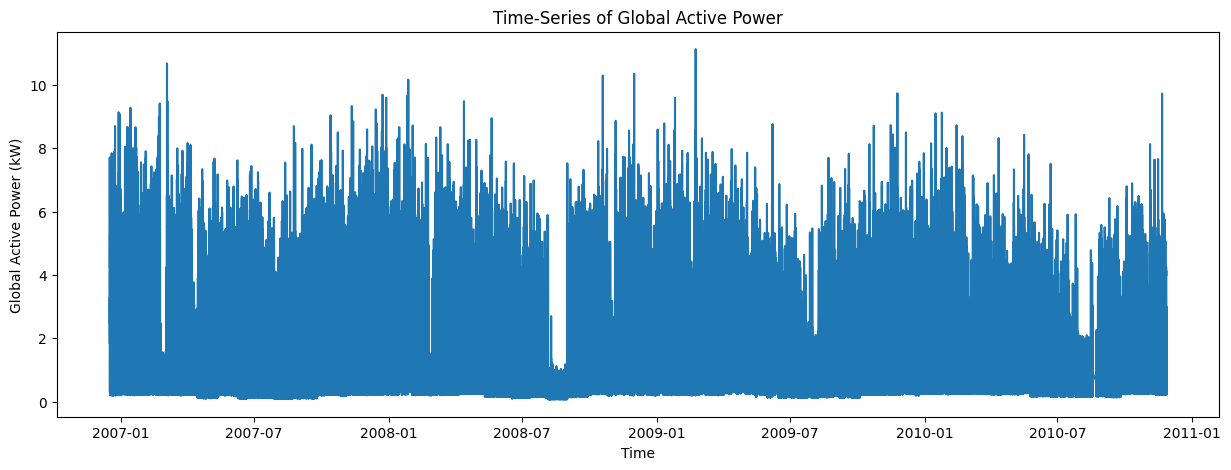

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df['Global_active_power'])
plt.title("Time-Series of Global Active Power")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.show()

***Below code Identifying missing or abnormal readings***

In [18]:
print("Negative values:", (df['Global_active_power'] < 0).sum())
print("Zero values:", (df['Global_active_power'] == 0).sum())
df['Global_active_power'].describe()

Negative values: 0
Zero values: 0


,Global_active_power
count,2.049280e+06
mean,1.091615e+00
std,1.057294e+00
min,7.600000e-02
25%,3.080000e-01
50%,6.020000e-01
75%,1.528000e+00
max,1.112200e+01


***Below code shows Hourly usage pattern as timeseries plot***

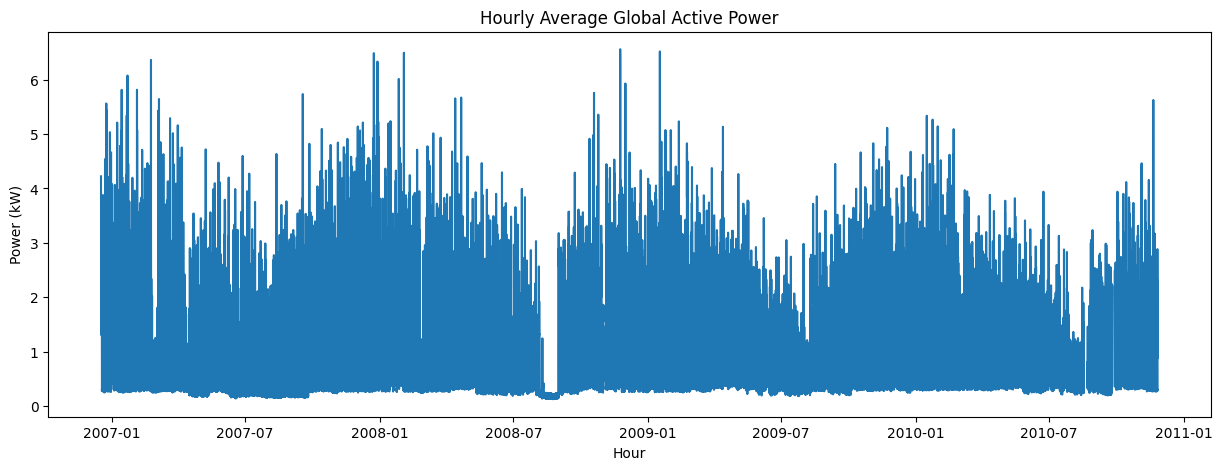

In [19]:
hourly = df['Global_active_power'].resample('h').mean()
plt.figure(figsize=(15,5))
plt.plot(hourly)
plt.title("Hourly Average Global Active Power")
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.show()

***Below code shows Daily usage pattern***

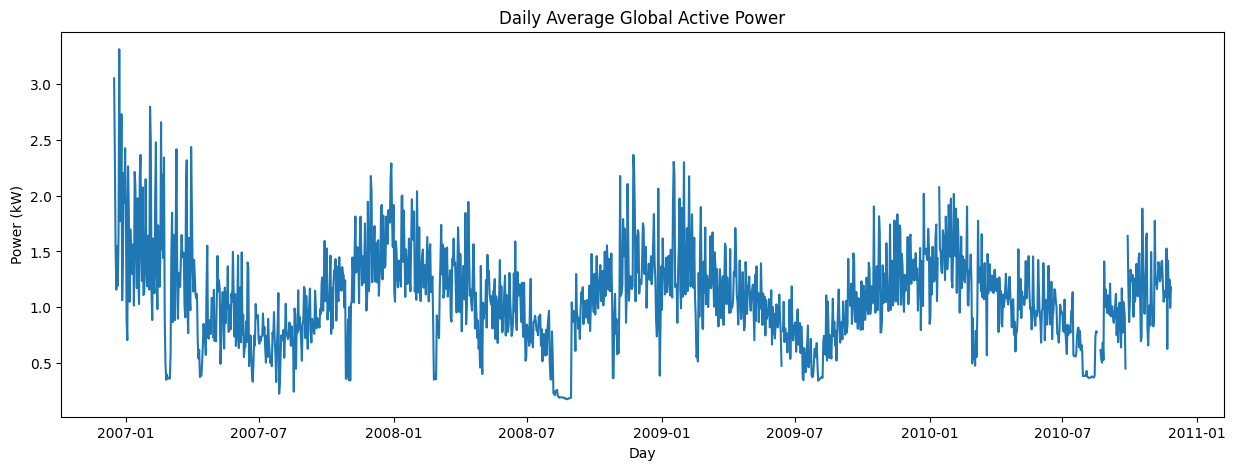

In [20]:
daily = df['Global_active_power'].resample('D').mean()
plt.figure(figsize=(15,5))
plt.plot(daily)
plt.title("Daily Average Global Active Power")
plt.xlabel("Day")
plt.ylabel("Power (kW)")
plt.show()

# **Task 2 — Supervised Learning (Time-Series Forecasting)**

**Preparing the timestamp and sort data (Timestamp is already created)**

In [21]:
df = df.sort_index()

***Prepare the windowed time-series dataset***

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
series = df['Global_active_power'].values
# 24 hours window
window_size = 24
generator = TimeseriesGenerator(series, series, length=window_size, batch_size=32)

***Train-test split (NO SHUFFLING)***

In [23]:
train_size = int(len(series) * 0.8)
train = series[:train_size]
test = series[train_size:]
#Making Generator
train_gen = TimeseriesGenerator(train, train, length=24, batch_size=64)
test_gen = TimeseriesGenerator(test, test, length=24, batch_size=64)

***Below code Builds a forecasting model***

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

model = Sequential([Input(shape=(24,1)), LSTM(64),Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

***Below code Train the model***

In [25]:
#history = model.fit(train_gen, epochs=20, batch_size=64, validation_data=test_gen)

***After training save and download the model for upcoming use usin below code***

In [43]:
#model.save("lstm_power_model.h5")
#from google.colab import files
#files.download("lstm_power_model.h5")

***Below code Predict on the test set***

In [27]:
predictions = model.predict(test_gen)

6404/6404 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


***Below code Evaluates the model by Mean absolute error(MAE) and Root Mean Squared error(RMSE)***

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
true_values = test[24:]
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.9901248987352124
RMSE: 1.3444912277052572


6404/6404 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step


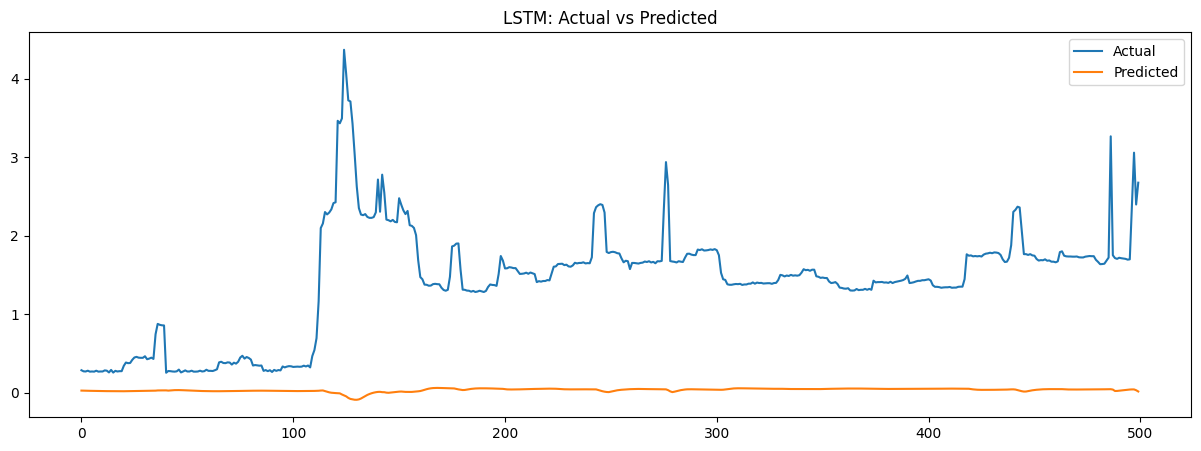

In [29]:
y_pred = model.predict(test_gen)
plt.figure(figsize=(15,5))
plt.plot(true_values[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.legend()
plt.title("LSTM: Actual vs Predicted")
plt.show()

# **Task 3 - Unsupervised Learning**

***Prepare daily consumption data***

In [53]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
daily_usage = df['Global_active_power'].resample('D').mean()
daily_usage = daily_usage.dropna()          # Drop missing days if any
daily_usage.head()

,Global_active_power
Timestamp,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


***Create feature dataframe***

In [31]:
features = pd.DataFrame()
features['daily_mean'] = daily_usage
features['daily_max'] = df['Global_active_power'].resample('D').max()
features['daily_min'] = df['Global_active_power'].resample('D').min()
features['daily_std'] = df['Global_active_power'].resample('D').std()
features = features.dropna()
features.head()

,daily_mean,daily_max,daily_min,daily_std
Timestamp,,,,
2006-12-16,3.053475,7.706,0.284,1.026338
2006-12-17,2.354486,7.064,0.206,1.205795
2006-12-18,1.530435,6.158,0.202,1.005074
2006-12-19,1.157079,7.840,0.194,1.237602
2006-12-20,1.545658,5.988,0.202,1.320968


***Scale the Data***

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features[:5]

array([[ 4.66707667,  1.38157645,  1.33485932,  0.34320461],
       [ 3.00388223,  1.00042069,  0.07068792,  0.91847022],
       [ 1.04310974,  0.46252796,  0.00585861,  0.27504224],
       [ 0.15473638,  1.46113233, -0.12379999,  1.02042999],
       [ 1.07933326,  0.36159887,  0.00585861,  1.2876649 ]])

***KMeans Clustering***

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
features['cluster'] = clusters
features.head()

,daily_mean,daily_max,daily_min,daily_std,cluster
Timestamp,,,,,
2006-12-16,3.053475,7.706,0.284,1.026338,2
2006-12-17,2.354486,7.064,0.206,1.205795,2
2006-12-18,1.530435,6.158,0.202,1.005074,2
2006-12-19,1.157079,7.840,0.194,1.237602,2
2006-12-20,1.545658,5.988,0.202,1.320968,2


***Visualize Clusters in 2D (using Principal Component Analysis(PCA))***

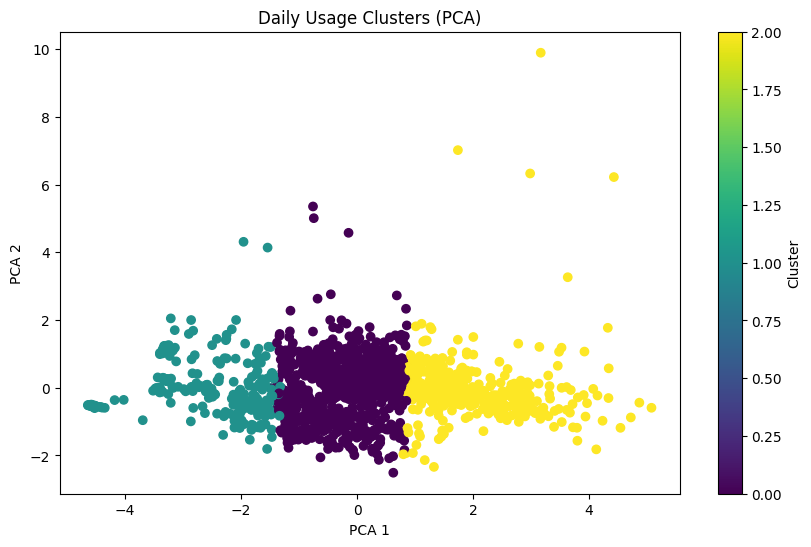

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
plt.figure(figsize=(10,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters, cmap='viridis')
plt.title("Daily Usage Clusters (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.show()

In [54]:
cluster_summary = features.groupby('cluster').mean()
cluster_summary

,daily_mean,daily_max,daily_min,daily_std,anomaly
cluster,,,,,
0,1.023374,5.301048,0.200843,0.879882,0.997475
1,0.535904,2.910975,0.151721,0.472948,0.959016
2,1.570862,7.051169,0.233904,1.272172,0.954660


***Anomaly Detection***

In [48]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
anomalies = iso.fit_predict(scaled_features)
features['anomaly'] = anomalies  # -1 = anomaly
features.head()

,daily_mean,daily_max,daily_min,daily_std,cluster,anomaly
Timestamp,,,,,,
2006-12-16,3.053475,7.706,0.284,1.026338,2,1
2006-12-17,2.354486,7.064,0.206,1.205795,2,1
2006-12-18,1.530435,6.158,0.202,1.005074,2,1
2006-12-19,1.157079,7.840,0.194,1.237602,2,1
2006-12-20,1.545658,5.988,0.202,1.320968,2,1


***Plot Anomalies***

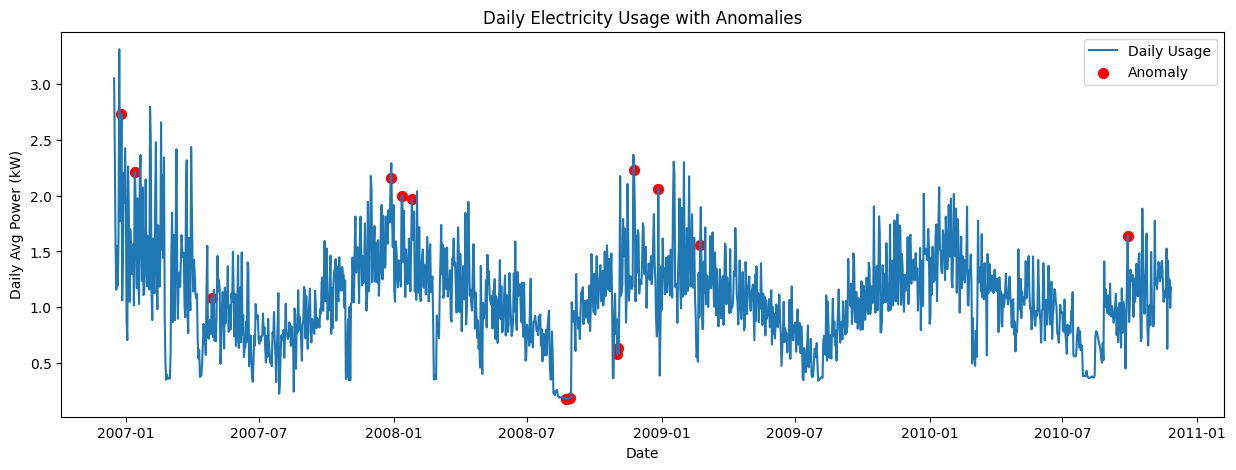

In [55]:
anomaly_days = features[features['anomaly'] == -1]
plt.figure(figsize=(15,5))
plt.plot(daily_usage, label='Daily Usage')
plt.scatter(anomaly_days.index, anomaly_days['daily_mean'], color='red', label='Anomaly', s=50)
plt.legend()
plt.title("Daily Electricity Usage with Anomalies")
plt.xlabel("Date")
plt.ylabel("Daily Avg Power (kW)")
plt.show()

# **Task 4 - Simple Consumption category Generator**

***Define rule-based usage category***

In [49]:
def usage_category(power):
    if power < 2.0:
        return "Low Usage"
    elif 2.0 <= power < 4.0:
        return "Medium Usage"
    else:
        return "High Usage"

***Apply the Rule on LSTM / RF Prediction***

In [50]:
y_pred = model.predict(test_gen)
y_pred = y_pred.flatten()   # convert to 1-D array
example_predicted_value = float(y_pred[0])   # first predicted test value
category = usage_category(example_predicted_value)
category

6404/6404 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step


'Low Usage'

***Suggestions based on category***

In [51]:
def usage_suggestion(category):
    if category == "Low Usage":
        return "Your consumption is low. Continue using electricity efficiently."
    elif category == "Medium Usage":
        return "Moderate consumption. Try switching off unused appliances to save energy."
    else:
        return "High usage detected! Consider reducing heavy appliance usage."

***Final output***

In [52]:
print("Predicted Power (kW):", round(example_predicted_value, 3))
print("Usage Category:", category)
print("Suggestion:", usage_suggestion(category))

Predicted Power (kW): 0.027
Usage Category: Low Usage
Suggestion: Your consumption is low. Continue using electricity efficiently.
